# Import modules

In [1]:
import sys, os
sys.path.append('../../tx-fast-hydrology')

import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

In [9]:
# Define time period 
startdate = '20220822'
enddate = '20220824'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%Y-%m-%d')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%Y-%m-%d')

# Date range to load
date_list = pd.date_range(startdate, enddate, freq='h', tz='utc')[:-1]

# Define path for NWM forcings
forcing_path = '../../densifimcation_shared/forcing/'+ startdate +'_event'

# Load model collection

In [10]:
# Define model file input path
input_path = '../../DensiFIMcation/data/shoal_waller_nwm.json'
# input_path = '../../cuahsi-summer-institute-2025/data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

In [11]:
model_collection.models.items()
forcing_path

'../../densifimcation_shared/forcing/20220822_event'

# Create model inputs

### Load NWM forcings

In [12]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

# View hdf streamflow for no_data_assimilation file (24-hour window) 
# pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')

# View hds streamflow for short_range forecast file (18-hours) 
# pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')

In [13]:
# print(streamflow.index)
# print(pd.to_datetime(streamflow.index, '%Y-%m-%d %H:%M:%S+00:00'))
temp = []
for i in streamflow.index: 
    # print(i)
    temp.append(pd.to_datetime(i, '%Y-%m-%d %H:%M:%S+00:00').date())

print(pd.DataFrame(temp, columns = ['dt'])['dt'].unique())

[datetime.date(2022, 8, 22) datetime.date(2022, 8, 23)]


### Create inputs to model based on forcings

In [15]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
for col in inputs.columns:
    if col in forcing.columns:
        inputs[col] = forcing[col]

# # Add inflow to upstream boundary reaches
# upstream_inputs = {
#     '5779305' : '5781161',
#     '5785187' : '5785899',
#     '5786029' : '5785351'
# }
# for downstream_reach, upstream_reach in upstream_inputs.items():
#     inputs[downstream_reach] += streamflow[upstream_reach]

In [16]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# inputs.head(n=5)

# Gather gage measurements for event period

In [17]:
# Download data from USGS dataretrieval
usgs_comid_df = pd.read_csv('../../cuahsi-summer-institute-2025/data/usgs_to_comid.csv', index_col=0)
usgs_comid_df['gage_id'] = usgs_comid_df['gage_id'].astype(str)
usgs_comid_df['comid'] = usgs_comid_df['comid'].astype(str)
# Filter 
usgs_comid_df = usgs_comid_df[usgs_comid_df['comid'].isin(input_columns)]

# Prepare gage IDs for USGS dataretrieval 
sites = usgs_comid_df.gage_id.dropna().astype(int).astype(str).reset_index(drop = True)
# sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
site_ids = []
for i in sites: 
    site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
# print(site_ids)
print('Number of gages: ' + str(len(site_ids)))

# Get site info 
TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
TCsites[0].head()

Number of gages: 4


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,08156675,"Shoal Ck at Silverway Dr, Austin, TX",ST,30.354167,-97.738889,S,NAD83,672.72,0.24,NAVD88,12090205,POINT (-97.73889 30.35417)
1,USGS,08156800,"Shoal Ck at W 12th St, Austin, TX",ST,30.276598,-97.750305,F,NAD83,455.45,0.22,NAVD88,12090205,POINT (-97.75031 30.2766)
2,USGS,08156910,"Waller Ck at Koenig Lane, Austin, TX",ST,30.322778,-97.722778,S,NAD83,644.60,0.16,NAVD88,12090205,POINT (-97.72278 30.32278)
3,USGS,08157540,"Waller Ck at Red River St, Austin, TX",ST,30.271628,-97.735558,5,NAD83,463.99,0.20,NAVD88,12090205,POINT (-97.73556 30.27163)


20220822
20220824
08156675
08157540
08156800
08156910


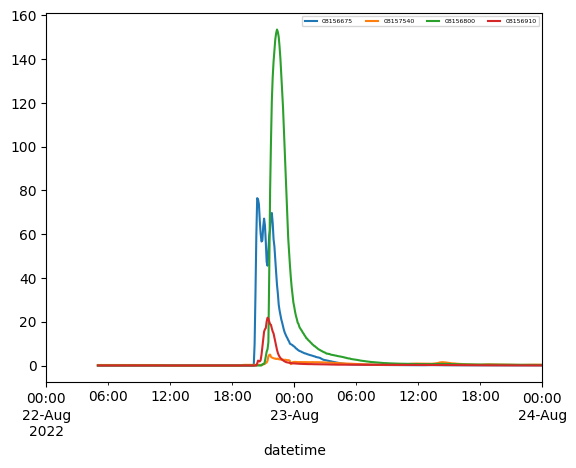

In [18]:
# Restructure data for h5 file 
eventdata = [] 
print(startdate)
print(enddate)

for i in list(set(site_ids)): 
    print(i)
    # fig, ax = plt.subplots()
    df = nwis.get_iv(sites=i, start=startdate_string, end=enddate_string, parameterCd='00060')
    df = pd.DataFrame(df[0])
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    else: 
        # ax.plot(df.index, df.iloc[:,1])
        print(i)
        print(df)
        # df1 = pd.DataFrame(df.iloc[:,1])
    # plt.suptitle(i)
    # plt.show()

df2 = (pd.concat(eventdata, axis = 1))
# print(df2)

# Convert cfs to cms 
df3 = df2*0.02831683199881

df3.plot()
plt.legend(ncol = 8, loc = 'upper right', prop = {'size' : 4.5})
plt.xlim(startdate, enddate)

df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_'+startdate+'_to_'+enddate+'_shoal_waller_nwm.h5', key = 'usgs', mode = 'w')

In [40]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_comid = pd.read_csv('../../cuahsi-summer-institute-2025/data/usgs_to_comid.csv', index_col=0)
usgs_to_comid['gage_id'] = usgs_to_comid['gage_id'].astype(str)
usgs_to_comid['comid'] = usgs_to_comid['comid'].astype(str)
# Filter 
usgs_to_comid = usgs_to_comid[usgs_to_comid['comid'].isin(input_columns)]
usgs_to_comid = pd.Series(usgs_to_comid['comid'].values, index=usgs_to_comid['gage_id'].values)
print(usgs_to_comid)
# Drop missing gages 
# usgs_to_comid = usgs_to_comid.drop(['8158922'])

# Load table of USGS gage measurements
# measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements = pd.read_hdf('../../densifimcation_shared/data/gage_data_usgs/gages_usgs_' + startdate + '_to_' + enddate + '_shoal_waller_nwm.h5', key = 'usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_comid.index]
print(measurements.head())
measurements.columns = measurements.columns.map(usgs_to_comid)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()
print(measurements.head())

8156675    5781223
8156800    5781703
8156910    5781313
8157540    5781313
dtype: object
                           8156675   8156800   8156910   8157540
datetime                                                        
2022-08-22 05:00:00+00:00      0.0  0.009345  0.006513  0.240976
2022-08-22 05:05:00+00:00      0.0  0.009345  0.006513  0.240976
2022-08-22 05:10:00+00:00      0.0  0.009345  0.006513  0.240976
2022-08-22 05:15:00+00:00      0.0  0.009345  0.006513  0.240976
2022-08-22 05:20:00+00:00      0.0  0.009345  0.006513  0.240976
                           5781223   5781703   5781313
datetime                                              
2022-08-22 05:00:00+00:00      0.0  0.009345  0.006513
2022-08-22 05:02:00+00:00      0.0  0.009345  0.006513
2022-08-22 05:04:00+00:00      0.0  0.009345  0.006513
2022-08-22 05:06:00+00:00      0.0  0.009345  0.006513
2022-08-22 05:08:00+00:00      0.0  0.009345  0.006513


In [41]:
input_columns

['5781313',
 '5781703',
 '5781223',
 '5781221',
 '5781907',
 '5781905',
 '5781903',
 '5781889',
 '5781887']

# Set up Kalman Filter

In [21]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n)
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and simulate model

### Prepare model for simulation

In [22]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [23]:
# Simulate models
outputs_da = await simulation.simulate()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

# Plot results

Text(0.5, 1.0, 'Travis County Model w/ DA: Discharge response to storm event on 2022-08-22')

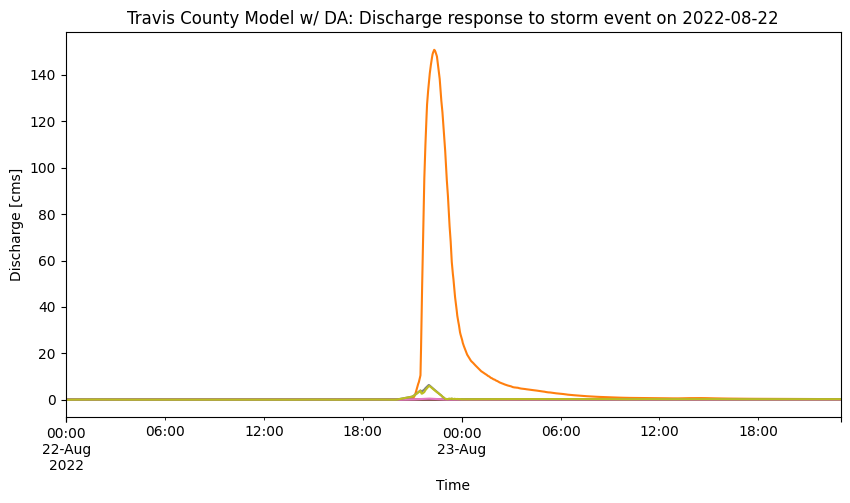

In [37]:
# New streamflow data 
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Travis County Model w/ DA: Discharge response to storm event on ' + startdate_string)
# plt.legend()

# Compare results

### Run model without DA

In [25]:
# Define model file input path
# input_path = '../../cuahsi-summer-institute-2025/data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

In [26]:
# View data 
outputs_noda.head()
outputs_noda.max()

# outputs_da.head()
# outputs_da.max()

5781313     0.000000
5781703    37.526516
5781223     0.000000
5781221     0.000000
5781907     0.000000
5781905     0.000000
5781903     0.534482
5781889     6.778893
5781887     6.819113
dtype: float64

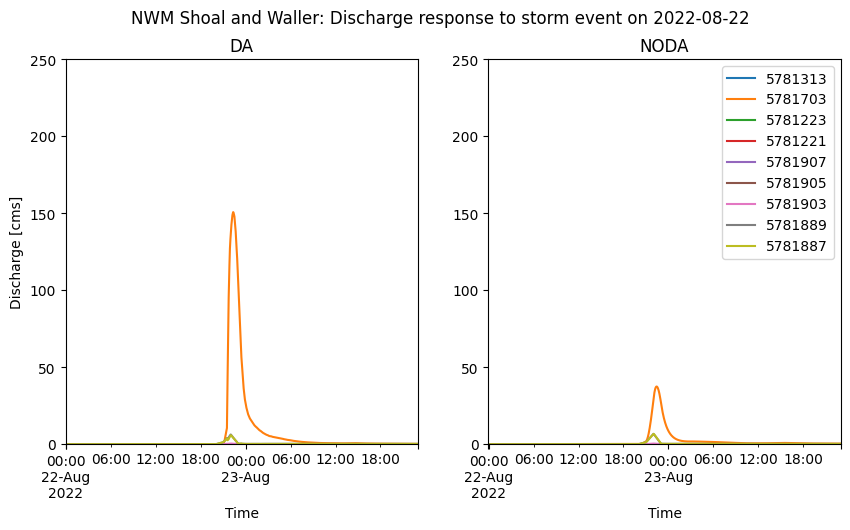

In [42]:
# Plot model output data 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex = True)
outputs_da.plot(ax=ax, legend=False)
outputs_noda.plot(ax=ax1, legend=False)
ax.set_title("DA")
ax1.set_title("NODA")
ax.set_xlabel('Time')
ax1.set_xlabel('Time')
ax.set_ylabel('Discharge [cms]')
fig.suptitle('NWM Shoal and Waller: Discharge response to storm event on ' + startdate_string)
ax.set_ylim(0,250)
ax1.set_ylim(0,250)
plt.legend()

In [ ]:
# Organize and export model ouptu data 
outputs = pd.concat([pd.DataFrame(outputs_da.max(), columns = ['q_cfs_da']), pd.DataFrame(outputs_noda.max(), columns = ['q_cfs_no_da'])], axis = 1)
outputs.index = outputs.index.astype(int)
outputs.index.name = 'ID'
print(outputs.index.name)
outputs = outputs * 35.314684921034 # convert back to cfs for ESRI geoprocessing 
# Save csv 
# outputs.to_csv('../../Project_Data/model_collection_with_da_'+ startdate + '.csv')

ID


    feature_id              name  strm_order    huc6  nwm_vers  high_water  \
693    5781161    Colorado River         6.0  120902       3.0     2915.53   
446    5785899     Cypress Creek         2.0  120902       3.0      900.26   
421    5785351  Pedernales River         4.0  120902       3.0     5069.17   

     rf_50_0_17  rf_25_0_17  rf_10_0_17  rf_5_0_17c  rf_2_0_17c   geom_Lengt  \
693    44416.71    25420.92    11781.29     6337.38     2502.76    68.737166   
446    12614.98     8775.18     4591.09     2252.38      426.91  5945.888382   
421   171139.36    94929.99    37138.19    14988.56     2435.97  8204.250122   

     IDInt                                           geometry  
693    NaN  LINESTRING (-10899003.683 3554063.971, -108990...  
446    NaN  LINESTRING (-10938542.357 3554131.31, -1093846...  
421    NaN  LINESTRING (-10932680.493 3543611.952, -109324...  


<Axes: >

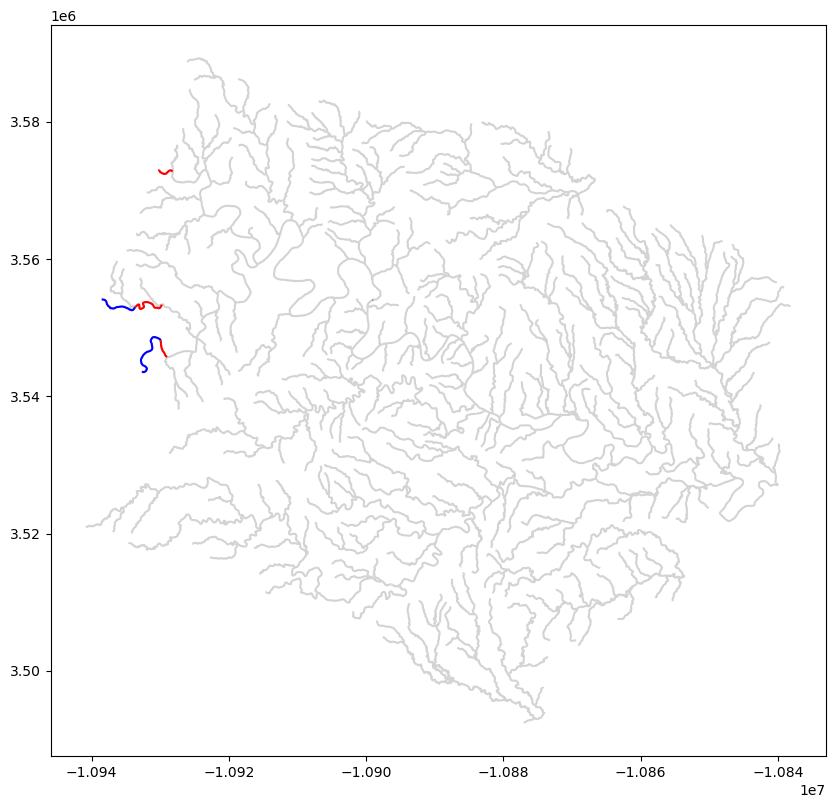

In [ ]:
# flowlines = gpd.read_file('../../Project_Data/TuesdayData/TuesdayData/TravisFlowlinesNWM.shp')
flowlines = gpd.read_file('../../densifimcation_shared/data/nwm_streams_tx')

outputs = pd.read_csv('../../Project_Data/model_collection_with_da_'+ startdate + '.csv')
# print(outputs.head())
fig, ax = plt.subplots(figsize = (10,10))
flowlines.plot(ax = ax, color = 'lightgray')
# print(flowlines.feature_id.astype(int))
# print(outputs.index)
# print(set(flowlines.feature_id.astype(int)) & set(outputs.ID))

upstream = ['5779305', '5785187', '5786029']
downstream = ['5781161', '5785899', '5785351']
up = []
dn = [] 
for i in upstream: 
    # print(flowlines[flowlines.feature_id == i])
    up.append(flowlines[flowlines.feature_id == i])
for j in downstream: 
    # print(flowlines[flowlines.feature_id == i])
    dn.append(flowlines[flowlines.feature_id == j])

up = pd.concat(up)
dn = pd.concat(dn)
print(dn)

up.plot(ax = ax, color = 'red')
dn.plot(ax = ax, color = 'blue')
# outputs

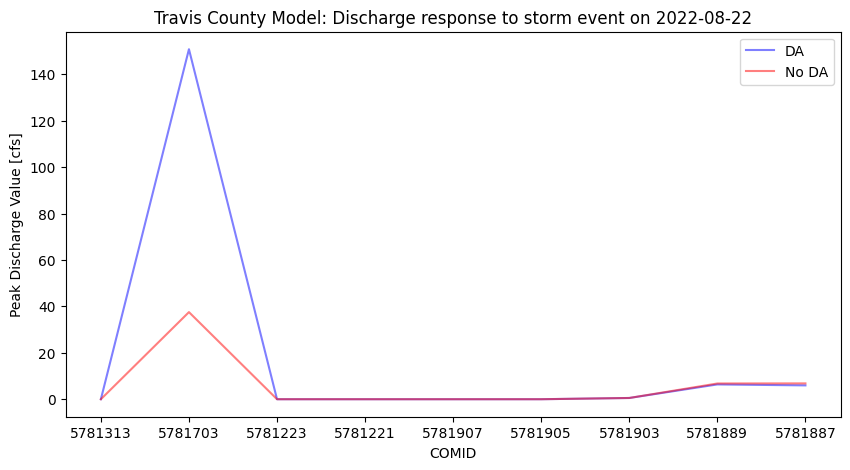

In [27]:
# New streamflow data 
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.max().plot(ax=ax, color = 'b', alpha = 0.5, label = 'DA', legend=False)
outputs_noda.max().plot(ax=ax, color = 'r', alpha = 0.5, label = 'No DA', legend=False)
plt.xlabel('COMID')
plt.ylabel('Peak Discharge Value [cfs]')
plt.title('Travis County Model: Discharge response to storm event on ' + startdate_string)
plt.legend()

### Plot model result vs. KF vs. measurements at gage locations

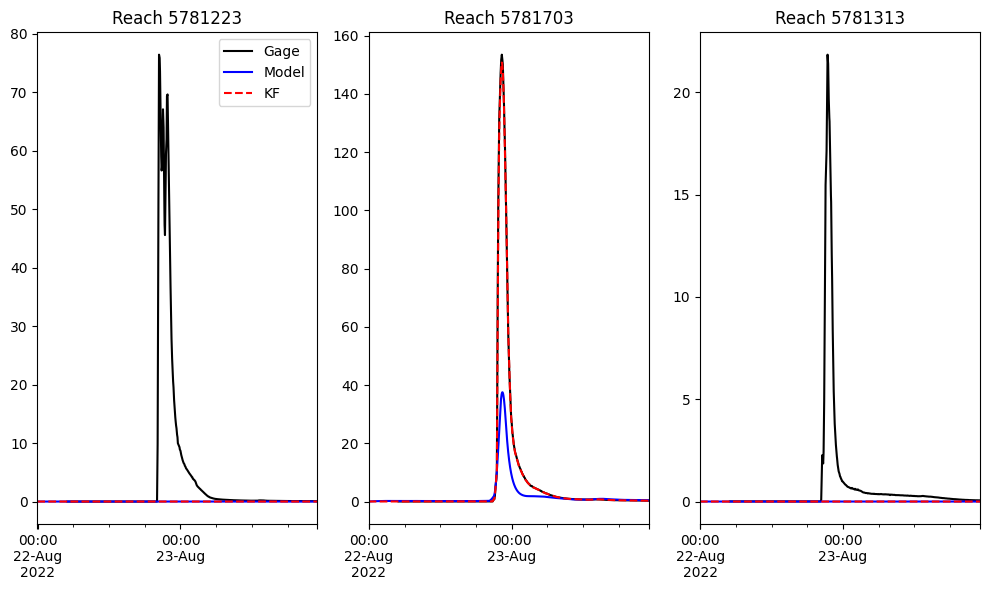

In [46]:
# New data 
fig, ax = plt.subplots(measurements.columns.size // 3, 3, figsize=(10, 6))

for index, comid in enumerate(measurements.columns):
    measurements[comid].plot(ax=ax.flat[index], c='k', label='Gage')
    outputs_noda[comid].plot(ax=ax.flat[index], c='b', label='Model')
    outputs_da[comid].plot(ax=ax.flat[index], c='r', linestyle = '--', label='KF')
    if index < measurements.columns.size - 3:
        ax.flat[index].xaxis.set_ticklabels([])
    ax.flat[index].xaxis.set_ticklabels([], minor=True)
    ax.flat[index].set_title(f'Reach {comid}')
    ax.flat[index].set_xlabel('')
ax.flat[0].legend()
plt.tight_layout()

### Plot map of gains

In [29]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [30]:
nwm_streams_tx = gpd.read_file('../../cuahsi-summer-institute-2025/data/nwm_streams_tx')
nwm_streams_tx['ID'] = nwm_streams_tx['ID'].astype(int).astype(str)
nwm_streams_travis = nwm_streams_tx[nwm_streams_tx['ID'].isin(input_columns)].copy()
nwm_streams_travis['gain'] = nwm_streams_travis['ID'].map(total_gain).fillna(0.).values
nwm_streams_travis['log_gain'] = np.log(1 + np.abs(nwm_streams_travis['gain'].values))

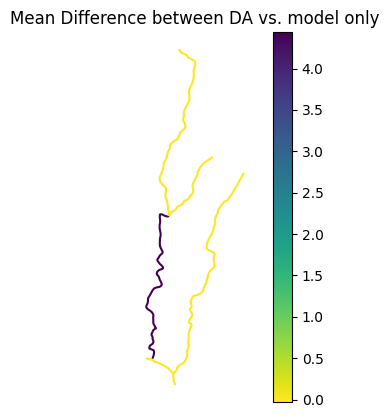

In [31]:
nwm_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title('Mean Difference between DA vs. model only')
_ = plt.axis('off')

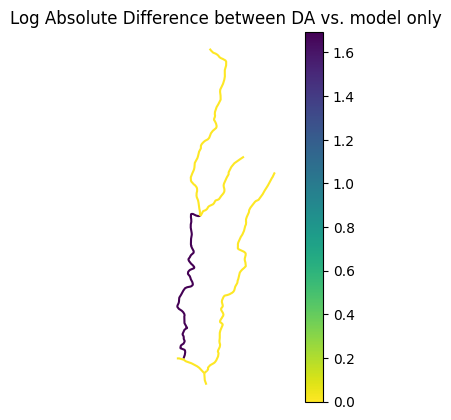

In [32]:
nwm_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title('Log Absolute Difference between DA vs. model only')
_ = plt.axis('off')